# PySQkit introduction

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pysqkit as sq
from pysqkit.util.linalg import tensor_prod

# Example single-qubit usage

In [3]:
# The fluxonium is taken by default in the double well configuration at half flux quantum

fluxonium = sq.qubits.Fluxonium(
    label= 'Q1', 
    joseph_energy=3.395, 
    charge_energy=0.479, 
    induct_energy=0.132, 
    dim_hilbert = 100
)

wf_dataset = fluxonium.wave_function(
    phase=np.linspace(-4*np.pi, 4*np.pi, 1000), 
    levels=range(3)
)

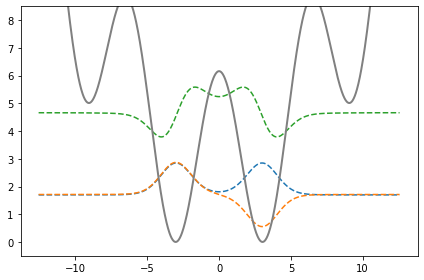

In [4]:
fig, ax = plt.subplots()

amp = 2*wf_dataset.joseph_energy/3
pot_offset = wf_dataset.potential.min()

shifted_wave_funcs = amp*wf_dataset.wave_func + wf_dataset.energy.data[:, np.newaxis] - pot_offset
for level in wf_dataset.level:
    ax.plot(wf_dataset.phase, shifted_wave_funcs.sel(level=level), '--')
    
ax.plot(wf_dataset.phase, (wf_dataset.potential - pot_offset), color='gray', lw=2)
ax.set_ylim(-0.5, 8.5)
plt.tight_layout()
plt.show()

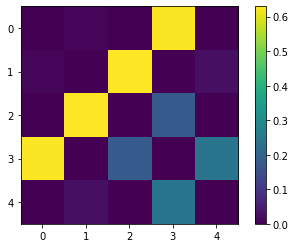

In [5]:
mat_elems = fluxonium.mat_elements(operator='charge_op', levels=5)
plt.imshow(np.abs(mat_elems))
plt.colorbar()
plt.show()

In [6]:
fluxonium.hamiltonian().shape

(100, 100)

In [12]:
levels_f = 5
eig_enegies, eig_states = fluxonium.eig_states(levels=levels_f)
# We can switch to the eigenbasis keeping only the first levels_f levels as
fluxonium.diagonalize_basis(levels_f)

In [13]:
diag_hamil = fluxonium.hamiltonian()

In [14]:
assert np.allclose(eig_enegies, np.diag(diag_hamil))

In [15]:
assert np.allclose(diag_hamil, np.diag(np.diag(diag_hamil)))

In [16]:
fluxonium.hamiltonian(as_qobj=True)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[-1.06987386e+00 -9.43946950e-16  1.14365179e-14 -2.14308455e-16
   1.12561218e-14]
 [-9.43946950e-16 -1.05599230e+00  6.85995590e-17  1.17537901e-16
   3.46276948e-15]
 [ 1.15062020e-14  6.85995590e-17  1.89492215e+00 -4.58968859e-16
  -4.20882432e-15]
 [-2.14308455e-16  1.52476559e-16 -4.58968859e-16  2.14840668e+00
   3.28261475e-15]
 [ 1.11053827e-14  3.46276948e-15 -4.12736139e-15  3.28261475e-15
   3.85387862e+00]]

Now all operators are automatically in the eigenbasis. For instance the charge operator is now given by

In [17]:
fluxonium.charge_op(as_qobj=True)

Quantum object: dims = [[5], [5]], shape = (5, 5), type = oper, isherm = True
Qobj data =
[[0.-4.61809559e-31j 0.+1.07895259e-02j 0.+2.45373815e-14j
  0.-6.25803383e-01j 0.+4.34412283e-16j]
 [0.-1.07895259e-02j 0.-7.98622754e-31j 0.-6.29809277e-01j
  0.-2.48803311e-14j 0.+2.66318601e-02j]
 [0.-2.45373815e-14j 0.+6.29809277e-01j 0.-3.23203770e-32j
  0.+1.82041298e-01j 0.-6.49857764e-16j]
 [0.+6.25803383e-01j 0.+2.48803311e-14j 0.-1.82041298e-01j
  0.+6.47834001e-32j 0.-2.45345327e-01j]
 [0.-4.34412283e-16j 0.-2.66318601e-02j 0.+6.49857764e-16j
  0.+2.45345327e-01j 0.+1.31044086e-30j]]

In [18]:
np.allclose(np.abs(mat_elems.data), np.abs(fluxonium.charge_op()))

True

## Example two-qubit usage

In [24]:
fluxonium_a = sq.qubits.Fluxonium(
    label='A', 
    joseph_energy=5.5, 
    charge_energy=1.5, 
    induct_energy=1, 
    dim_hilbert = 100
)

# It is advisable to always work in the bare eigenbasis before coupling to
# other systems

fluxonium_a.diagonalize_basis(levels_f)

fluxonium_b = sq.qubits.Fluxonium(
    label='B', 
    joseph_energy=5.7, 
    charge_energy=1.2, 
    induct_energy=1, 
    dim_hilbert = 100
)

fluxonium_b.diagonalize_basis(levels_f)

jc = 0.2 # capacitive coupling strength in GHz
coupled_sys = fluxonium_a.couple_to(fluxonium_b, coupling=sq.couplers.capacitive_coupling, strength=0.2)

In [25]:
sys_hamil = coupled_sys.hamiltonian()
bare_hamil = coupled_sys.bare_hamiltonian()
int_hamil = coupled_sys.int_hamiltonian()

In [26]:
bare_hamil.shape

(25, 25)

In [27]:
assert(np.allclose(sys_hamil, bare_hamil+int_hamil))

In [32]:
_, eig_states = fluxonium_a.eig_states(levels=levels_f)

_, eig_states = fluxonium_b.eig_states(levels=levels_f)

In [33]:
diag_hamil_a = fluxonium_a.hamiltonian()
diag_hamil_b = fluxonium_b.hamiltonian()

In [35]:
np.allclose(bare_hamil, tensor_prod([diag_hamil_a, np.eye(*diag_hamil_b.shape)]) + tensor_prod([np.eye(*diag_hamil_a.shape), diag_hamil_b]))

True

In [36]:
cap_coupling = sq.couplers.capacitive_coupling(
    qubits=[fluxonium_a, fluxonium_b],
    strength = 0.2,
)

In [37]:
cap_coupling.hamiltonian().shape

(25, 25)

In [38]:
np.allclose(int_hamil, cap_coupling.hamiltonian())

True

In [39]:
also_cap_coupling = sq.Coupling(
    prefactors=0.2,
    operators=dict(A=fluxonium_a.charge_op(), B=fluxonium_b.charge_op()),
    qubits=['A', 'B']
)

In [40]:
np.allclose(int_hamil, also_cap_coupling.hamiltonian())

True

In [41]:
double_cap_coupling = sq.Coupling(
    prefactors=[0.2, 0.2],
    operators=[dict(A=fluxonium_a.charge_op(), B=fluxonium_b.charge_op()), dict(A=fluxonium_a.charge_op(), B=fluxonium_b.charge_op())],
    qubits=['A', 'B']
)

In [42]:
np.allclose(2*int_hamil, double_cap_coupling.hamiltonian())

True